In [1]:
import matplotlib.pyplot as plt
from matplotlib import lines as mlines
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats import proportion

import src
from src import pandas_utils as pdu
from src import vis
from src import _constants as C

FILE_SNVS = "data/final/gnomad_snrna_variants_hwe_stats_snvs.tsv"
FILE_PS = "data/stats/snv_proportion_singletons_by_gene_type.tsv"
FILE_EXCESS_HETS="data/final/oe_outliers_bonferroni_significant.tsv"
PNG = "data/plots/snrna_allele_frequency.png"
SVG = "data/plots/snrna_allele_frequency.svg"

In [2]:
df_snvs = pd.read_csv(FILE_SNVS, sep="\t").check.head(3)

<h5 style='text-align: left'><span style='color:None; background-color:None'>First 3 rows</span></h5>

,ac,af,gene_type
0,74963,0.500,snRNA
1,33678,0.409,snRNA
2,29963,0.329,Pseudogene


In [3]:
df_ps = pd.read_csv(FILE_PS, sep="\t").check.head()

<h5 style='text-align: left'><span style='color:None; background-color:None'>First 5 rows</span></h5>

,gene_type,n_singletons,n_variants,proportion_singletons,ci_lo,ci_hi,err_lo,err_hi
0,Pseudogene,13847,26482,0.523,0.517,0.529,0.006,0.006
1,snRNA,868,2162,0.401,0.381,0.422,0.021,0.021


In [4]:
df_xs_het = pd.read_csv(FILE_EXCESS_HETS, sep="\t")

KS statistics: P=2.02e-51 D=0.171
Two-sided Z test of proportions: P=1.8e-27


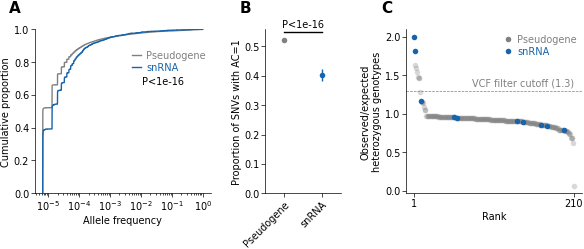

In [16]:
plt.style.use("src/default.mpltstyle")

fig, axs = plt.subplots(
    1,
    3,
    figsize=(15 / 2.54, 6.5 / 2.54),
    width_ratios=[7, 3, 7],
    layout="constrained",
    gridspec_kw=dict(wspace=0.1),
)

# Plot cumulative frequency distribution
dfg = df_snvs.groupby("gene_type")
colors = [C.COLOR_PSEUDO, C.COLOR_SNRNA]

for (label, data), color in zip(dfg, colors):
    x = data["af"]
    axs[0].ecdf(x, color=color, label=label)

axs[0].set_xscale("log")
axs[0].legend(loc="best", bbox_to_anchor=(0.5, 0.5, 0.5, 0.4))
axs[0].set_ylabel("Cumulative proportion")
axs[0].set_xlabel("Allele frequency")

# Add statistics
af_pseudo, af_snrna = [data["af"] for _, data in dfg]

ks_res = stats.kstest(af_pseudo, af_snrna)
ks_p = ks_res.pvalue
ks_d = ks_res.statistic
print(f"KS statistics: P={ks_p:.3n}", f"D={ks_d:.3n}")

p_cutoff = 10**-16
p_label = f"P<{p_cutoff}"

axs[0].annotate(
    p_label,
    xy=(0.85, 0.65),
    xycoords="axes fraction",
    va="bottom",
    ha="right",
)

# Plot proportion of singletons
for (group, row), color in zip(df_ps.iterrows(), colors):
    axs[1].errorbar(
        x=row["gene_type"],
        y=row["proportion_singletons"],
        yerr=[[row["err_lo"]], [row["err_hi"]]],
        color=color,
        marker="o",
    )

# Add statistics
_, z_pval = proportion.proportions_ztest(df_ps["n_singletons"], df_ps["n_variants"])

print(f"Two-sided Z test of proportions: P={z_pval:.3n}")

z_pval_clipped = max(z_pval, 1e-16)
vis.annotate_stats_horizontal_line(f"P<{z_pval_clipped}", 0, 1, y=0.55, ax=axs[1])

# Tidy axes
axs[1].set_ylabel("Proportion of SNVs with AC=1")
axs[1].set_xlim(-0.5, 1.5)
axs[1].set_xticks(
    axs[1].get_xticks(),
    labels=axs[1].get_xticklabels(),
    rotation=45,
    ha="right",
    rotation_mode="anchor",
)
axs[1].autoscale(axis="y")
axs[1].set_ylim(bottom=0)

# Plot excess hets
df_het_g = df_xs_het.groupby("gene_type")
colors = [C.COLOR_PSEUDO, C.COLOR_SNRNA]
alphas = [0.3, 1]
for (gene_type, data), color, alpha in zip(df_het_g, colors, alphas):
    x = data["rank"]
    y = data["oe"]
    axs[2].scatter(x, y, label=gene_type, color=color, alpha=alpha, lw=0)

# Inbreeding coefficient filter cutoff
axs[2].axhline(1.3, color="grey", lw=0.5, ls="--", alpha=1, zorder=-1)
axs[2].annotate(
    "VCF filter cutoff (1.3)",
    xy=(210, 1.3),
    xycoords="data",
    xytext=(0, 2),
    textcoords="offset points",
    color="grey",
    ha="right",
    va="bottom",
)

axs[2].set_xticks([f(df_xs_het["rank"]) for f in [min, max]])
axs[2].set_ylabel("Observed/expected\nheterozygous genotypes")
axs[2].set_xlabel("Rank")

# Add legend
marker_pseudo = mlines.Line2D(
    [], [], color=C.COLOR_PSEUDO, marker="o", linestyle="None", label="Pseudogene"
)
marker_snrna = mlines.Line2D(
    [], [], color=C.COLOR_SNRNA, marker="o", linestyle="None", label="snRNA"
)

axs[2].legend(handles=[marker_pseudo, marker_snrna], loc="upper right")

# Add panel labels
for ax, label in zip(axs, "ABC"):
    vis.panel_label(ax, label, fontsize=11)

# Save figure
plt.savefig(PNG, dpi=600)
plt.savefig(SVG)